# **0. Environment set up**

In [ ]:
# Connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%pip install rasterio --quiet
%pip install matplotlib --quiet
%pip install scipy --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 48.1 MB/s eta 0:00:00


In [ ]:
# Import modules
import os
from pathlib import Path
from datetime import datetime
import rasterio
from rasterio import plot as rio_plot
import random
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, cohen_kappa_score

from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
!pip install earthpy --quiet
import earthpy.plot as ep

# Turn off scientific notation in printing for ease of reading
np.set_printoptions(suppress=True)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 62.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 74.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 60.9 MB/s eta 0:00:00


In [ ]:
# Set seeds
seed = 123
np.random.seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

# **1. Data preparation**

In [ ]:
# Base folder
base = '/content/drive/My Drive/Thesis2'

# Load image and make it readable as a numpy matrix
def open_raster(raster_path):
    with rasterio.open(raster_path, 'r') as ds:
        return ds.read() 

# Image and label for training and validation
img1 = open_raster(base+'/Data/TrainImg_spk.tif')
img1[np.isnan(img1)] =0
img1 = np.squeeze(img1)

img1_gt = open_raster(base+'/Data/TrainSubLbl.tif')
img1_gt[np.isnan(img1_gt)] = 0
img1_gt[img1_gt < 0] = 0
img1_gt = np.squeeze(img1_gt)

# Image and label for testing
img2 = open_raster(base+'/Data/TestImg_spk.tif')
img2[np.isnan(img2)] =0
img2 = np.squeeze(img2)

img2_gt = open_raster(base+'/Data/TestSubLbl.tif')
img2_gt[np.isnan(img2_gt)] = 0
img2_gt[img2_gt < 0] = 0
img2_gt = np.squeeze(img2_gt)

In [ ]:
# Class colors
class_colors_dict = {
    'Background':      [0.5, 0.5, 0.5, 1],
    'Water':     [0,   0,   1,   1],   
    'Bare soil':     [1,   0,   1,   1],
    'Regrowth forest':     [0,   1,   0,   1],
    'Dense forest':     [0,   0.5,   0,   1],
    'Mature plantation':     [0.7,   0.7,   0,   1],
    'Young plantation':     [1,   1,   0,   0.5], 
}
class_colors = [v for k,v in class_colors_dict.items()]
class_cm = np.array(class_colors)

# Get color map of image 1
gt_values_in_img1 = np.unique(img1_gt).astype(int)
img1_class_map = class_cm[gt_values_in_img1]
img1_cmap = ListedColormap(img1_class_map)

# Get color map of image 2
gt_values_in_img2 = np.unique(img2_gt).astype(int)
img2_class_map = class_cm[gt_values_in_img2]
img2_cmap = ListedColormap(img2_class_map)

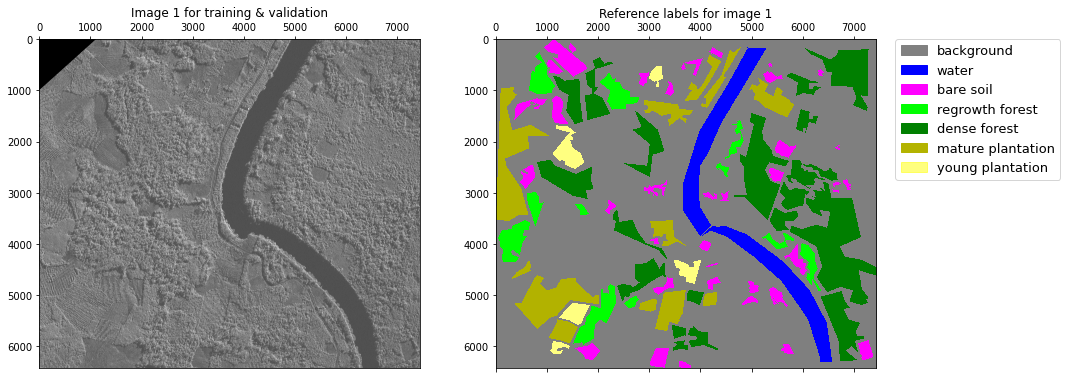

In [ ]:
# Plot the training/validation image and label
fig, (ax_img1, ax_img1_gt) = plt.subplots(1, 2, figsize=(15, 15))
rio_plot.show(img1, ax=ax_img1, cmap='gray', vmin=0, vmax=0.6)
ax_img1.xaxis.set_ticks_position('top')
ax_img1.set_title("Image 1 for training & validation")

im = ax_img1_gt.matshow(img1_gt, cmap=img1_cmap)
ax_img1_gt.set_title("Reference labels for image 1")
ep.draw_legend(im, titles=["background", "water", "bare soil", "regrowth forest", "dense forest", "mature plantation", "young plantation"])

plt.show(fig)

# **2. Data splitting**

In [ ]:
# Training validation split
val_frac = 0.14
fraction_index = round(val_frac * img1.shape[0]) # Split along vertical axis

training_matrix = img1[fraction_index:, :]
training_matrix_labels = img1_gt[fraction_index:, :]

validation_matrix = img1[:fraction_index, :]
validation_matrix_labels = img1_gt[:fraction_index, :]

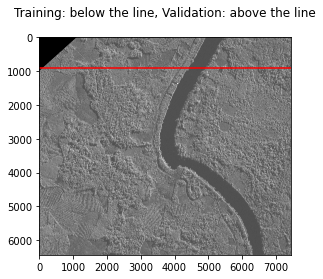

In [ ]:
# Make a simple matrix where validation cells are marked with a 1
splits_fig = np.zeros_like(img1_gt)
splits_fig[fraction_index:, :] = 1

x=[0, img1.shape[1]]
y=[img1.shape[0]*0.14, img1.shape[0]*0.14]

## Plot the splits used for training
plt.plot(x, y, color='r')
plt.imshow(img1, cmap='gray', vmin=0, vmax=0.6)
plt.title("Training: below the line, Validation: above the line" "\n")
plt.show()

In [ ]:
# Flatten the splits
train_pixels = training_matrix.reshape(training_matrix.shape[0] * training_matrix.shape[1])
train_labels = training_matrix_labels.reshape(training_matrix.shape[0] * training_matrix.shape[1])

val_pixels = validation_matrix.reshape(validation_matrix.shape[0] * validation_matrix.shape[1])
val_labels = validation_matrix_labels.reshape(validation_matrix_labels.shape[0] * validation_matrix_labels.shape[1])

# 1D to 2D
train_pixels = np.reshape(train_pixels, (-1,1))
val_pixels = np.reshape(val_pixels, (-1,1))

# Remove background from the arrays
train_pixels = train_pixels[train_labels != 0]
train_labels = train_labels[train_labels != 0]
val_pixels = val_pixels[val_labels != 0]
val_labels = val_labels[val_labels != 0]

In [ ]:
# Merge the matrices so that the sampling picks the same elements
subset_matrix = np.concatenate([train_pixels, train_labels[:, None]], axis=1)

# Training data size
n_pixels = int( 144000 / 6 )

subset_matrix_water = subset_matrix[subset_matrix[:,1]==1]
subset_matrix_baresoil = subset_matrix[subset_matrix[:,1]==2]
subset_matrix_regrowth = subset_matrix[subset_matrix[:,1]==3]
subset_matrix_dense = subset_matrix[subset_matrix[:,1]==4]
subset_matrix_mature = subset_matrix[subset_matrix[:,1]==5]
subset_matrix_young = subset_matrix[subset_matrix[:,1]==6]

subset_idx_water = np.random.choice(subset_matrix_water.shape[0], n_pixels, replace=False)
subset_idx_baresoil = np.random.choice(subset_matrix_baresoil.shape[0], n_pixels, replace=False)
subset_idx_regrowth = np.random.choice(subset_matrix_regrowth.shape[0], n_pixels, replace=False)
subset_idx_dense = np.random.choice(subset_matrix_dense.shape[0], n_pixels, replace=False)
subset_idx_mature = np.random.choice(subset_matrix_mature.shape[0], n_pixels, replace=False)
subset_idx_young = np.random.choice(subset_matrix_young.shape[0], n_pixels, replace=False)

subset_water = subset_matrix_water[subset_idx_water, :]
subset_baresoil = subset_matrix_baresoil[subset_idx_baresoil, :]
subset_regrowth = subset_matrix_regrowth[subset_idx_regrowth, :]
subset_dense = subset_matrix_dense[subset_idx_dense, :]
subset_mature = subset_matrix_mature[subset_idx_mature, :]
subset_young = subset_matrix_young[subset_idx_young, :]

subset = np.concatenate((subset_water, subset_baresoil, subset_regrowth, subset_dense, subset_mature, subset_young))

# Separate the arrays of the image and label
train_pixels = subset[:,:-1]
train_labels = subset[:,-1]

In [ ]:
# Merge the matrices so that the sampling picks the same elements
subset_matrix_val = np.concatenate([val_pixels, val_labels[:, None]], axis=1)

# Validation data size
n_pixels_val = int( 18000 / 6 )

subset_matrix_water_val = subset_matrix_val[subset_matrix_val[:,1]==1]
subset_matrix_baresoil_val = subset_matrix_val[subset_matrix_val[:,1]==2]
subset_matrix_regrowth_val = subset_matrix_val[subset_matrix_val[:,1]==3]
subset_matrix_dense_val = subset_matrix_val[subset_matrix_val[:,1]==4]
subset_matrix_mature_val = subset_matrix_val[subset_matrix_val[:,1]==5]
subset_matrix_young_val = subset_matrix_val[subset_matrix_val[:,1]==6]

subset_idx_water_val = np.random.choice(subset_matrix_water_val.shape[0], n_pixels_val, replace=False)
subset_idx_baresoil_val = np.random.choice(subset_matrix_baresoil_val.shape[0], n_pixels_val, replace=False)
subset_idx_regrowth_val = np.random.choice(subset_matrix_regrowth_val.shape[0], n_pixels_val, replace=False)
subset_idx_dense_val = np.random.choice(subset_matrix_dense_val.shape[0], n_pixels_val, replace=False)
subset_idx_mature_val = np.random.choice(subset_matrix_mature_val.shape[0], n_pixels_val, replace=False)
subset_idx_young_val = np.random.choice(subset_matrix_young_val.shape[0], n_pixels_val, replace=False)

subset_water_val = subset_matrix_water_val[subset_idx_water_val, :]
subset_baresoil_val = subset_matrix_baresoil_val[subset_idx_baresoil_val, :]
subset_regrowth_val = subset_matrix_regrowth_val[subset_idx_regrowth_val, :]
subset_dense_val = subset_matrix_dense_val[subset_idx_dense_val, :]
subset_mature_val = subset_matrix_mature_val[subset_idx_mature_val, :]
subset_young_val = subset_matrix_young_val[subset_idx_young_val, :]

subset_val = np.concatenate((subset_water_val, subset_baresoil_val, subset_regrowth_val, subset_dense_val, subset_mature_val, subset_young_val))

# Separate the arrays of the image and label
val_pixels = subset_val[:,:-1]
val_labels = subset_val[:,-1]

# **3. Model parameter tuning**

In [ ]:
# Set grid search parameters
n_trees_range = [100, 200, 300, 400, 500]
min_samples_range = [150, 300, 450, 600, 750]

# prepare matrix for storing the matrics reached on the validation set per parameter combination
acc_paramsearch = np.ndarray([len(n_trees_range), len(min_samples_range)])
precision_paramsearch = np.ndarray([len(n_trees_range), len(min_samples_range)])
recall_paramsearch = np.ndarray([len(n_trees_range), len(min_samples_range)])
f1_paramsearch = np.ndarray([len(n_trees_range), len(min_samples_range)])
kappa_paramsearch = np.ndarray([len(n_trees_range), len(min_samples_range)])

# the time it takes to train models
time_paramsearch = np.ndarray([len(n_trees_range), len(min_samples_range)])

In [ ]:
# Perform the parameter searching and keep track of performance
for n_trees_index, n_trees in enumerate(n_trees_range):
    for min_leaves_index, min_samples in enumerate(min_samples_range):
        print(f"N trees: {n_trees}, Min. samples samples per leaf: {min_samples}")
        
        # Initialize the random forest classifier
        model = RandomForestClassifier(n_estimators=n_trees, min_samples_split=min_samples)
        
        # Fit the classifier to the training data/labels
        start = datetime.now()
        model.fit(train_pixels, train_labels)
        end = datetime.now()
        time_taken = float(f"{(end - start).seconds}.{round((end - start).microseconds, 2)}")

        # Use the model to predict all of the validation pixels
        predictions = model.predict(val_pixels)

        # Calculate the accuracy of the predicted labels vs the ground truth labels
        acc = accuracy_score(predictions, val_labels)
        precision = precision_score(predictions, val_labels, average=None)
        recall = recall_score(predictions, val_labels, average=None)
        f1 = 2*precision*recall / (precision + recall)
        kappa = cohen_kappa_score(predictions, val_labels)

        # Store accuracies and time taken for this parameter combination
        acc_paramsearch[n_trees_index, min_leaves_index] = round(acc, 3)
        precision_paramsearch[n_trees_index, min_leaves_index] = round(np.mean(precision), 3)
        recall_paramsearch[n_trees_index, min_leaves_index] = round(np.mean(recall), 3)
        f1_paramsearch[n_trees_index, min_leaves_index] = round(np.mean(f1), 3)
        kappa_paramsearch[n_trees_index, min_leaves_index] = round(kappa, 3)
        time_paramsearch[n_trees_index, min_leaves_index] = round(time_taken, 3)

In [ ]:
# Plot the validation results
n_trees_labels = [0] + n_trees_range
min_leaves_labels = [0] + min_samples_range 

fig, ((ax_acc, ax_pre), (ax_rec, ax_f1), (ax_kap, ax_time)) = plt.subplots(3, 2, figsize=(15,15))

## Plot accuracy
ax_acc.set_title("Overall Accuracy", weight='bold')
ax_acc.set(xlabel='Number of trees', ylabel='Min samples per leaf')
ax_acc.set_xticklabels(n_trees_labels)
ax_acc.set_yticklabels(min_leaves_labels)
ax_acc.matshow(acc_paramsearch.T, cmap=plt.get_cmap('coolwarm_r'))

## Plot precision
ax_pre.set_title("Average precision", weight='bold')
ax_pre.set(xlabel='Number of trees', ylabel='Min samples per leaf')
ax_pre.set_xticklabels(n_trees_labels)
ax_pre.set_yticklabels(min_leaves_labels)
ax_pre.matshow(precision_paramsearch.T, cmap=plt.get_cmap('coolwarm_r'))

## Plot recall
ax_rec.set_title("Average recall", weight='bold')
ax_rec.set(xlabel='Number of trees', ylabel='Min samples per leaf')
ax_rec.set_xticklabels(n_trees_labels)
ax_rec.set_yticklabels(min_leaves_labels)
ax_rec.matshow(recall_paramsearch.T, cmap=plt.get_cmap('coolwarm_r'))

## Plot f1
ax_f1.set_title("Average f1", weight='bold')
ax_f1.set(xlabel='Number of trees', ylabel='Min samples per leaf')
ax_f1.set_xticklabels(n_trees_labels)
ax_f1.set_yticklabels(min_leaves_labels)
ax_f1.matshow(f1_paramsearch.T, cmap=plt.get_cmap('coolwarm_r'))

## Plot kappa
ax_kap.set_title("Kappa score", weight='bold')
ax_kap.set(xlabel='Number of trees', ylabel='Min samples per leaf')
ax_kap.set_xticklabels(n_trees_labels)
ax_kap.set_yticklabels(min_leaves_labels)
ax_kap.matshow(kappa_paramsearch.T, cmap=plt.get_cmap('coolwarm_r'))

## Plot time taken
ax_time.set_title("Time Taken in Seconds", weight='bold')
ax_time.set(xlabel='Number of trees', ylabel='Min samples per leaf')
ax_time.set_xticklabels(n_trees_labels)
ax_time.set_yticklabels(min_leaves_labels)
ax_time.matshow(time_paramsearch.T, cmap=plt.get_cmap('coolwarm_r'))

## Add text to plots
for t_i, t_val in enumerate(n_trees_range):
    for l_i, l_val in enumerate(min_samples_range):
        ax_acc.text(t_i, l_i, s=acc_paramsearch[t_i, l_i], ha='center')
        ax_pre.text(t_i, l_i, s=precision_paramsearch[t_i, l_i], ha='center')
        ax_rec.text(t_i, l_i, s=recall_paramsearch[t_i, l_i], ha='center')
        ax_f1.text(t_i, l_i, s=f1_paramsearch[t_i, l_i], ha='center')
        ax_kap.text(t_i, l_i, s=kappa_paramsearch[t_i, l_i], ha='center')
        ax_time.text(t_i, l_i, s=time_paramsearch[t_i, l_i], ha='center')

# **4. Model training**

In [ ]:
# Random forest classifier with the selected parameters
num_trees = 200
min_num_leaves = 450

model = RandomForestClassifier(
    n_estimators = num_trees, 
    min_samples_split = min_num_leaves,
    oob_score = True)

# Run the classifier on the entire training set
train_start = datetime.now()
model.fit(train_pixels, train_labels)
train_end = datetime.now()
time_taken = float(f"{(train_end - train_start).seconds}.{round((train_end - train_start).microseconds, 2)}")

# Check training accuracy
train_preds = model.predict(train_pixels)
train_acc = accuracy_score(train_preds, train_labels)

# Run the model on the validation pixels
val_preds = model.predict(val_pixels)
val_acc = accuracy_score(val_preds, val_labels)

print(f'Training accuracy:   {train_acc:.4f}')
print(f'Validation accuracy: {val_acc:.4f}')
print(f'Training time:       {time_taken:.3f} seconds')

Training accuracy:   0.4474
Validation accuracy: 0.4023
Training time:       77.239 seconds


# **5. Inference**

In [ ]:
# Make a matrix to store the prediction results in
test_results_matrix = np.ones_like(img2_gt)

# Apply the model on every row of the input image.
for xdim_index in range(img2.shape[0]):
    test_row = img2[xdim_index,:]
    test_row_preds = model.predict(np.reshape(test_row, (-1,1)))
    test_results_matrix[xdim_index,:] = test_row_preds

# **6. Prediction quality control**

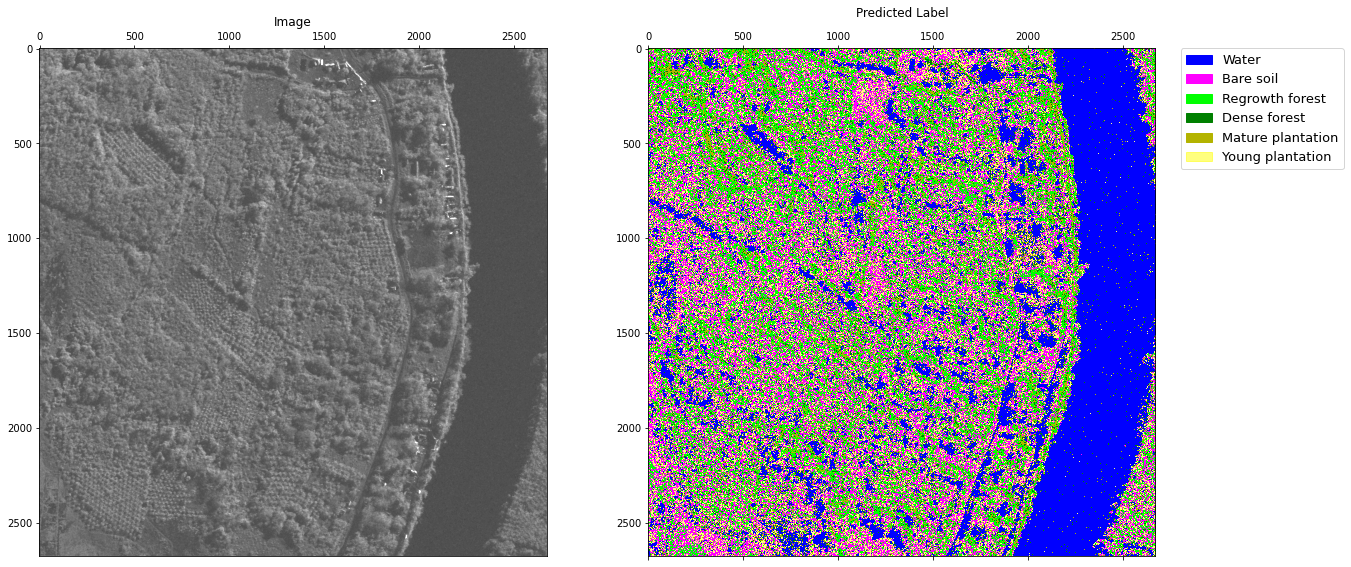

In [ ]:
# Wall-to-wall prediction

# Class colors
class_colors = {
    'Water':     [0,   0,   1,   1],   
    'Bare soil':     [1,   0,   1,   1],
    'Regrowth forest':     [0,   1,   0,   1],
    'Dense forest':     [0,   0.5,   0,   1],
    'Mature plantation':     [0.7,   0.7,   0,   1],
    'Young plantation':     [1,   1,   0,   0.5], 
}
cm = np.array([v for k,v in class_colors.items()])

values = np.unique(img2_gt).astype(int)
class_map = cm[np.delete(np.unique(values), np.unique(values).max()).astype(int)]
cmap = ListedColormap(class_map)

# Create plots for the images
fig, (ax_img2, ax_img2_pred) = plt.subplots(1, 2, figsize=(20,20))
rio_plot.show(img2, ax=ax_img2, cmap='gray', vmin=0, vmax=0.6)
ax_img2.xaxis.set_ticks_position('top')
ax_img2.set_title("Image")

im = ax_img2_pred.matshow(test_results_matrix, cmap=cmap)
ax_img2_pred.set_title("Predicted Label")

ep.draw_legend(im, titles=["Water", "Bare soil", "Regrowth forest", "Dense forest", "Mature plantation", "Young plantation"])

plt.show(fig)

In [ ]:
# Test image prediction

test_results_matrix[img2_gt == 0] = 0

# Create plots for the images
fig, (ax_img2, ax_img2_gt, ax_img2_pred) = plt.subplots(1, 3, figsize=(20,20))
rio_plot.show(img2, ax=ax_img2, cmap='gray', vmin=0, vmax=0.6)
ax_img2.xaxis.set_ticks_position('top')
ax_img2.set_title("Image 2")

ax_img2_gt.matshow(img2_gt, cmap=img2_cmap)
ax_img2_gt.set_title("Reference labels for image 2")

ax_img2_pred.matshow(test_results_matrix, cmap=img2_cmap)
ax_img2_pred.set_title("Predictions of the final model")

ep.draw_legend(im, titles=["background", "water", "bare soil", "regrowth forest", "dense forest", "mature plantation", "young plantation"])

plt.show(fig)

In [ ]:
# Reference label and prediction without background
gt_zeros_removed = img2_gt[img2_gt != 0]
preds_zeros_removed = test_results_matrix[img2_gt != 0]

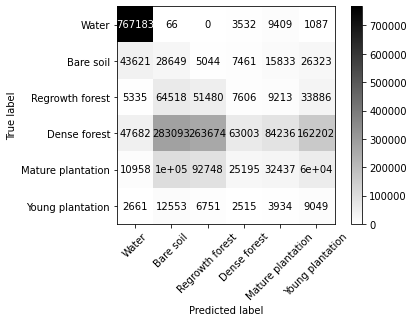

In [ ]:
# Get matrix labels
labels = [k for i, k in enumerate(class_colors_dict) if i in set(gt_zeros_removed)]
# Make confusion matrix
conf_matrix = confusion_matrix(gt_zeros_removed.ravel(), preds_zeros_removed.ravel())
conf_matrix_viewer = ConfusionMatrixDisplay(conf_matrix, display_labels=labels)
conf_matrix_viewer.plot(cmap=plt.get_cmap('binary'), xticks_rotation=45)

In [ ]:
# Calculate the metrics
test_precisions = precision_score(gt_zeros_removed.ravel(), preds_zeros_removed.ravel(), average=None)
test_recalls = recall_score(gt_zeros_removed.ravel(), preds_zeros_removed.ravel(), average=None)
test_F1score = 2 * test_precisions * test_recalls / (test_precisions + test_recalls)
test_kappa = cohen_kappa_score(gt_zeros_removed.ravel(), preds_zeros_removed.ravel())
test_acc = accuracy_score(gt_zeros_removed.ravel(), preds_zeros_removed.ravel())

# Print these for each class separately
print("Test set precision scores per class")
for i, label in enumerate(labels):
    print(f"{label}: {test_precisions[i]:.4f}")
print("\n")
print("Test set recall scores per class")
for i, label in enumerate(labels):
    print(f"{label}: {test_recalls[i]:.4f}") 
print("\n")
print("Test set F1 scores per class")
for i, label in enumerate(labels):
    print(f"{label}: {test_F1score[i]:.4f}") 
print("\n")
print(f"Test set Kappa score: {test_kappa:.4f}")
print("\n")
print(f'Test avarage accuracy:   {sum(test_recalls)/lentest_recalls):.4f}')
print(f'Test overall accuracy:   {test_acc:.4f}')

Test set precision scores per class
Water: 0.8743
Bare soil: 0.0584
Regrowth forest: 0.1227
Dense forest: 0.5764
Mature plantation: 0.2092
Young plantation: 0.0310


Test set recall scores per class
Water: 0.9820
Bare soil: 0.2257
Regrowth forest: 0.2992
Dense forest: 0.0697
Mature plantation: 0.1004
Young plantation: 0.2415


Test set F1 scores per class
Water: 0.9250
Bare soil: 0.0927
Regrowth forest: 0.1740
Dense forest: 0.1244
Mature plantation: 0.1357
Young plantation: 0.0549


Test set Kappa score: 0.2771


Test set per class accuracy
Water: 0.9820
Bare soil: 0.2257
Regrowth forest: 0.2992
Dense forest: 0.0697
Mature plantation: 0.1004
Young plantation: 0.2415


Test avarage accuracy:   0.3198
Test overall accuracy:   0.4060


# **7. Save the prediction result**

In [ ]:
# Save the predicted raster
from rasterio.transform import Affine
img = rasterio.open(base + "/Data/TestSubLbl.tif")
with rasterio.open(
        base+'/Results/PredSub.tif',
        mode="w",
        driver="GTiff",
        height=test_results_matrix.shape[0],
        width=test_results_matrix.shape[1],
        count=1,
        dtype=test_results_matrix.dtype,
        crs=img.crs,
        transform=img.transform,
) as new_dataset:
        new_dataset.write(test_results_matrix, 1)

# Optional: calculate the weight for the DL input and visualize the value ranges of each class in the training set

In [ ]:
# Calculate class weight
weight, proportion = [0.00], [0.00]
n_class = 6
class_count = [len(img1_gt[img1_gt==1]), len(img1_gt[img1_gt==2]), len(img1_gt[img1_gt==3]), len(img1_gt[img1_gt==4]), len(img1_gt[img1_gt==5]), len(img1_gt[img1_gt==6])]
total_data = len(img1_gt[img1_gt!=0])
for amount in class_count:
  weight.append( round(total_data / (n_class * amount) , 2) )
  proportion.append( round(amount/total_data, 4) )
print(proportion)
print(weight)

[0.0, 0.1365, 0.1089, 0.101, 0.4022, 0.2106, 0.0408]
[0.0, 1.22, 1.53, 1.65, 0.41, 0.79, 4.09]


/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


(array([1, 2, 3, 4, 5, 6]), <a list of 6 Text major ticklabel objects>)

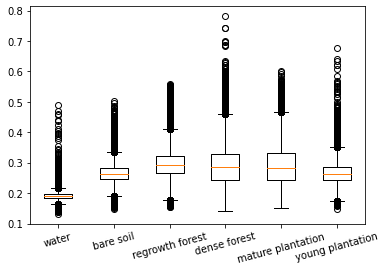

In [ ]:
# Visualize value range of each class in the training set
water = training_matrix[training_matrix_labels==1]
bare = training_matrix[training_matrix_labels==2]
reg = training_matrix[training_matrix_labels==3]
dense = training_matrix[training_matrix_labels==4]
mature = training_matrix[training_matrix_labels==5]
young = training_matrix[training_matrix_labels==6]

plt.boxplot(
    [water, bare, reg, dense, mature, young],
    labels=["water", "bare soil", "regrowth forest", "dense forest", "mature plantation", "young plantation"],
)
plt.xticks(rotation=15)